In [2]:
import os
import pandas as pd
import nba_api.stats.endpoints
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
import time
from nba_api.stats.library.parameters import *

def calculate_plus_minus(df):
    # Create a boolean column for home games
    df['HOME_GAME'] = ~df['MATCHUP'].str.contains('@')

    # Calculate the total points for each game and whether it's a home game
    game_points = df.groupby('GAME_ID')['PTS'].transform('sum')

    # Calculate the plus-minus
    df['PLUS_MINUS'] = df['PTS'] - (game_points - df['PTS'])

    #df.loc[df['HOME_GAME'], 'PLUS_MINUS'] *= -1

    return df


nba_teams = teams.get_teams()
fp_team = "./data/all_games.parquet.gzip"

if not os.path.exists(fp_team):
    print("data not found")
    all_games = pd.DataFrame()

    for team in nba_teams:
        team_id = team.get('id')
        gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=team_id,league_id_nullable=LeagueIDNullable().nba, season_type_nullable=SeasonType().regular)

        team_games = gamefinder.get_data_frames()[0]
        all_games = pd.concat([all_games, team_games])
    all_games.to_parquet(fp_team, index=False)
else:
    print("data found local")
    all_games = pd.read_parquet(fp_team)

all_games['GAME_DATE'] = pd.to_datetime(all_games['GAME_DATE'])
all_games = all_games.sort_values(['GAME_DATE', 'GAME_ID']).reset_index(drop=True)

# Apply the function to calculate plus-minus
all_games = calculate_plus_minus(all_games)
all_games['DAYS_SINCE_LAST_GAME'] = all_games.groupby(['SEASON_ID','TEAM_ID'])['GAME_DATE'].diff().dt.days

hom = all_games.loc[all_games['HOME_GAME']]
awy = all_games.loc[~all_games['HOME_GAME']]



data found local


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Concatenate, Normalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

# Load the data
data = all_games.copy()

# Define the features and targets
features = ['MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']
target_win = 'WL'
target_plus_minus = 'PLUS_MINUS'

# Handle missing values
data[features] = data[features].apply(lambda x: x.fillna(x.mean()), axis=0)

# Convert target win/loss to binary
data[target_win] = data[target_win].apply(lambda x: 1 if x == 'W' else 0)

# Create lagged features
def create_lagged_features(df, group_col, features, lag=1):
    df_lagged = df.copy()
    for feature in features:
        df_lagged[f'{feature}_lag{lag}'] = df.groupby(group_col)[feature].shift(lag)
    return df_lagged

# Create sequences
def create_sequences(data, features, sequence_length=10):
    sequences = []
    targets_win = []
    targets_plus_minus = []
    
    for team_id, group in data.groupby('TEAM_ID'):
        for i in range(sequence_length, len(group)):
            seq = group.iloc[i-sequence_length:i][features].values
            sequences.append(seq)
            targets_win.append(group.iloc[i][target_win])
            targets_plus_minus.append(group.iloc[i][target_plus_minus])
    
    return np.array(sequences), np.array(targets_win), np.array(targets_plus_minus)

# Apply lagged features and remove NaNs created by shifting
data = create_lagged_features(data, 'TEAM_ID', features, lag=1).dropna()

# Separate home and away games
home_games = data.loc[data['HOME_GAME']]
away_games = data.loc[~data['HOME_GAME']]


In [8]:
import pandas as pd

def find_identical_columns(df1, df2):
    # Find columns that exist in both data frames
    common_columns = set(df1.columns).intersection(set(df2.columns))
    
    identical_columns = []
    
    for col in common_columns:
        if df1[col].equals(df2[col]):
            identical_columns.append(col)
    
    return identical_columns

identical_columns = find_identical_columns(home_games.select_dtypes('number').abs(), away_games.select_dtypes('number').abs())
print("Identical columns:", identical_columns)

Identical columns: []


In [3]:
home_games

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT_lag1,OREB_lag1,DREB_lag1,REB_lag1,AST_lag1,STL_lag1,BLK_lag1,TOV_lag1,PF_lag1,PLUS_MINUS_lag1
19,21983,1610612762,UTH,Utah Jazz,0028300010,1983-10-29,UTH vs. LAL,0,240,115,...,0.781,10.0,27.0,37.0,32.0,6.0,8.0,7.0,30.0,-14.0
20,21983,1610612752,NYK,New York Knicks,0028300011,1983-10-29,NYK vs. WAS,1,240,100,...,0.657,16.0,19.0,35.0,26.0,9.0,3.0,17.0,33.0,15.0
24,21983,1610612744,GOS,Golden State Warriors,0028300013,1983-10-29,GOS vs. POR,1,240,97,...,0.703,21.0,26.0,47.0,26.0,11.0,2.0,19.0,34.0,1.0
26,21983,1610612737,ATL,Atlanta Hawks,0028300014,1983-10-29,ATL vs. DET,1,240,117,...,0.684,15.0,18.0,33.0,14.0,10.0,5.0,17.0,30.0,-18.0
31,21983,1610612746,SDC,San Diego Clippers,0028300016,1983-10-29,SDC vs. DEN,1,240,141,...,0.750,7.0,24.0,31.0,19.0,5.0,5.0,18.0,31.0,-14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93305,22023,1610612760,OKC,Oklahoma City Thunder,0022301196,2024-04-14,OKC vs. DAL,1,241,135,...,0.900,8.0,30.0,38.0,29.0,13.0,5.0,10.0,12.0,18.0
93306,22023,1610612759,SAS,San Antonio Spurs,0022301197,2024-04-14,SAS vs. DET,1,241,123,...,0.696,11.0,38.0,49.0,31.0,2.0,4.0,18.0,13.0,1.0
93308,22023,1610612744,GSW,Golden State Warriors,0022301198,2024-04-14,GSW vs. UTA,1,239,123,...,0.762,11.0,42.0,53.0,27.0,6.0,5.0,16.0,15.0,-5.0
93311,22023,1610612746,LAC,LA Clippers,0022301199,2024-04-14,LAC vs. HOU,0,240,105,...,0.684,20.0,24.0,44.0,23.0,9.0,7.0,13.0,17.0,-1.0


In [ ]:

# Prepare sequences for home and away games
home_sequences, home_targets_win, home_targets_plus_minus = create_sequences(home_games, [f'{feat}_lag1' for feat in features])
away_sequences, away_targets_win, away_targets_plus_minus = create_sequences(away_games, [f'{feat}_lag1' for feat in features])

# Split the data into training and testing sets (80/20 split)
X_home_train, X_home_test, y_home_win_train, y_home_win_test, y_home_pm_train, y_home_pm_test = train_test_split(
    home_sequences, home_targets_win, home_targets_plus_minus, test_size=0.2, random_state=42)

X_away_train, X_away_test, y_away_win_train, y_away_win_test, y_away_pm_train, y_away_pm_test = train_test_split(
    away_sequences, away_targets_win, away_targets_plus_minus, test_size=0.2, random_state=42)

# Normalize features
normalizer_home = Normalization(axis=-1)
normalizer_home.adapt(X_home_train)

normalizer_away = Normalization(axis=-1)
normalizer_away.adapt(X_away_train)

# Define model inputs
home_input = Input(shape=(X_home_train.shape[1], X_home_train.shape[2]), name="home_input")
away_input = Input(shape=(X_away_train.shape[1], X_away_train.shape[2]), name="away_input")

# Apply normalization
norm_home = normalizer_home(home_input)
norm_away = normalizer_away(away_input)

# RNN layers
lstm_home = LSTM(64, activation='relu')(norm_home)
lstm_away = LSTM(64, activation='relu')(norm_away)

# Concatenate the inputs
concatenated = Concatenate()([lstm_home, lstm_away])

# Dense layers
dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)
dense4 = Dense(16, activation='relu')(dense3)

# Output layer for binary classification (Home win or not)
output_home_win = Dense(1, activation='sigmoid', name="home_win")(dense4)

# Output layer for regression (Point difference)
output_point_diff = Dense(1, name="point_diff")(dense4)

# Create the model
model = Model(inputs=[home_input, away_input], outputs=[output_home_win, output_point_diff])

# Compile the model
model.compile(optimizer='adam',
              loss={'home_win': 'binary_crossentropy', 'point_diff': 'mean_squared_error'},
              metrics={'home_win': 'accuracy', 'point_diff': 'mse'})

# Visualize the model structure
plot_model(model, show_shapes=True, show_layer_names=True, dpi=75)

# Train the model
history = model.fit(
    [X_home_train, X_away_train], {'home_win': y_home_win_train, 'point_diff': y_home_pm_train},
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_results = model.evaluate([X_home_test, X_away_test], {'home_win': y_home_win_test, 'point_diff': y_home_pm_test}, verbose=1)

In [38]:
home_sequences

array([[[240., 108.,  41., ...,  17.,  30., -18.],
        [240., 117.,  49., ...,  23.,  35.,   2.],
        [240.,  95.,  38., ...,  16.,  34.,   3.],
        ...,
        [240., 102.,  42., ...,  15.,  26.,  -7.],
        [240., 115.,  41., ...,  14.,  24.,   6.],
        [240.,  92.,  37., ...,  19.,  33., -36.]],

       [[240., 117.,  49., ...,  23.,  35.,   2.],
        [240.,  95.,  38., ...,  16.,  34.,   3.],
        [240., 105.,  40., ...,  12.,  34., -30.],
        ...,
        [240., 115.,  41., ...,  14.,  24.,   6.],
        [240.,  92.,  37., ...,  19.,  33., -36.],
        [240., 102.,  37., ...,  10.,  19.,  11.]],

       [[240.,  95.,  38., ...,  16.,  34.,   3.],
        [240., 105.,  40., ...,  12.,  34., -30.],
        [240., 107.,  45., ...,  18.,  26.,   5.],
        ...,
        [240.,  92.,  37., ...,  19.,  33., -36.],
        [240., 102.,  37., ...,  10.,  19.,  11.],
        [240., 104.,  46., ...,  11.,  20.,  -6.]],

       ...,

       [[241., 111.,  44

In [ ]:
# Separate home and away games
home_games = data[data['HOME_GAME'] == True]
away_games = data[data['HOME_GAME'] == False]


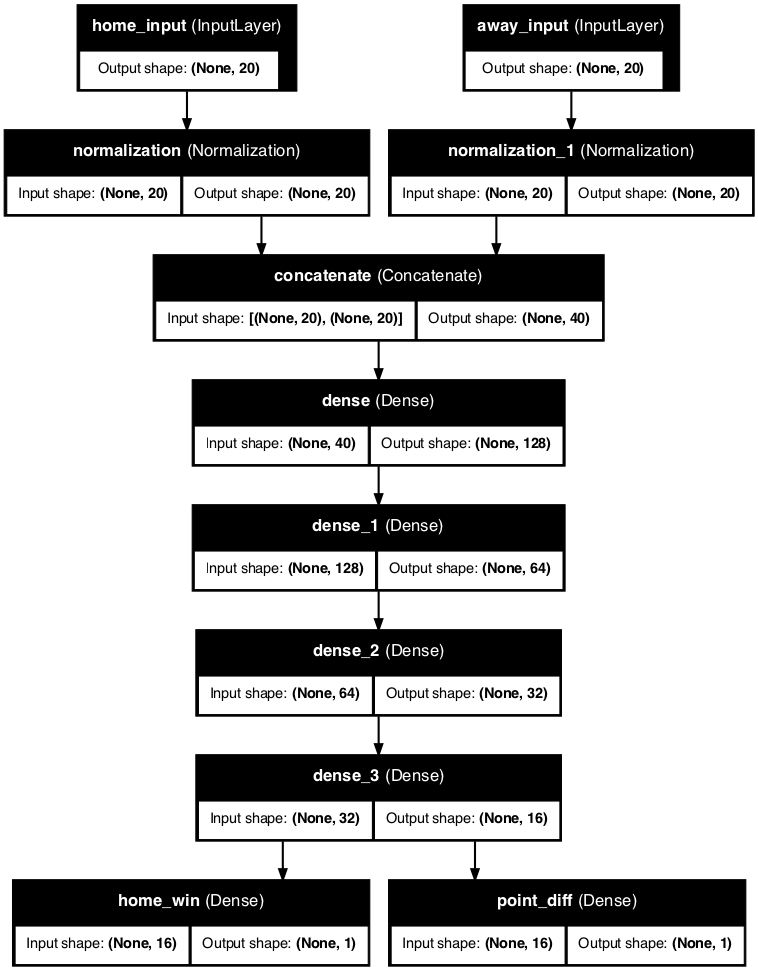

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Normalization
from tensorflow.keras.utils import plot_model

tf.keras.backend.clear_session()

train_df = final_df.copy()

# Assuming df is your DataFrame loaded from the SQLite database
# Fill NaN values with the mean of each column (or choose another method)
train_df[home_features] = train_df[home_features].apply(lambda x: x.fillna(x.mean()), axis=0)
train_df[away_features] = train_df[away_features].apply(lambda x: x.fillna(x.mean()), axis=0)

# Normalize the input features
normalizer_home = Normalization(axis=-1)
normalizer_home.adapt(train_df[home_features].to_numpy())

normalizer_away = Normalization(axis=-1)
normalizer_away.adapt(train_df[away_features].to_numpy())

# Define model inputs
home_input = Input(shape=(len(home_features),), name="home_input")
away_input = Input(shape=(len(away_features),), name="away_input")

# Apply normalization
norm_home = normalizer_home(home_input)
norm_away = normalizer_away(away_input)

# Concatenate the inputs
concatenated = Concatenate()([norm_home, norm_away])

# Define the rest of the model
dense1 = Dense(128, activation='relu')(concatenated)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)
dense4 = Dense(16, activation='relu')(dense3)

# Output layer for binary classification (Home win or not)
output_home_win = Dense(1, activation='sigmoid', name="home_win")(dense4)

# Output layer for regression (Point difference)
output_point_diff = Dense(1, name="point_diff")(dense4)

# Create the model
model = Model(inputs=[home_input, away_input], outputs=[output_home_win, output_point_diff])

# Compile the model
model.compile(optimizer='adam',
              loss={'home_win': 'binary_crossentropy', 'point_diff': 'mean_squared_error'},
              metrics={'home_win': 'accuracy', 'point_diff': 'mse'})

# Visualize the model structure
plot_model(model, show_shapes=True, show_layer_names=True, dpi=75)

Epoch 1/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - home_win_accuracy: 0.8168 - loss: 72.9923 - point_diff_mse: 72.5856 - val_home_win_accuracy: 0.7516 - val_loss: 106.4607 - val_point_diff_mse: 105.9391
Epoch 2/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - home_win_accuracy: 0.8164 - loss: 72.1096 - point_diff_mse: 71.7085 - val_home_win_accuracy: 0.7505 - val_loss: 109.9212 - val_point_diff_mse: 109.3940
Epoch 3/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - home_win_accuracy: 0.8220 - loss: 71.2862 - point_diff_mse: 70.8903 - val_home_win_accuracy: 0.7497 - val_loss: 108.0357 - val_point_diff_mse: 107.5131
Epoch 4/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - home_win_accuracy: 0.8191 - loss: 69.5965 - point_diff_mse: 69.1994 - val_home_win_accuracy: 0.7491 - val_loss: 109.1315 - val_point_diff_mse: 108.6028
Epoch 5/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - home_win_accuracy: 0.8262 - loss: 68.6723 - point_diff_mse: 68.2817 - val_home_win_accuracy: 0.7481 - val_loss: 

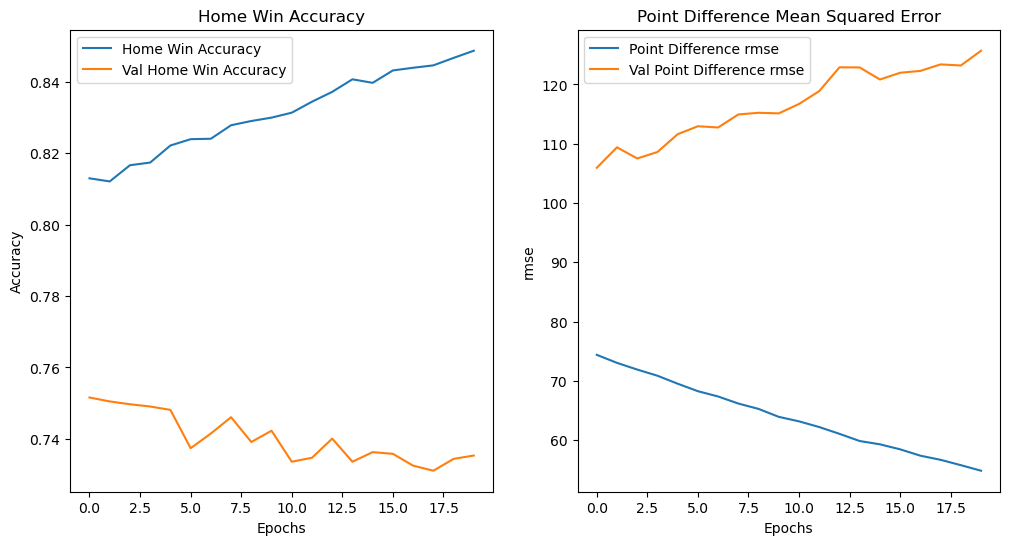

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Prepare data for training
X_home = train_df[home_features].to_numpy()
X_away = train_df[away_features].to_numpy()
y_home_win = train_df['home_win'].to_numpy()
y_point_diff = train_df['point_diff'].to_numpy()

# Split the data into training and testing sets (80/20 split)
X_home_train, X_home_test, X_away_train, X_away_test, y_home_win_train, y_home_win_test, y_point_diff_train, y_point_diff_test = train_test_split(
    X_home, X_away, y_home_win, y_point_diff, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    [X_home_train, X_away_train], {'home_win': y_home_win_train, 'point_diff': y_point_diff_train},
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluate the model on the test set
test_results = model.evaluate([X_home_test, X_away_test], {'home_win': y_home_win_test, 'point_diff': y_point_diff_test}, verbose=1)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['home_win_accuracy'], label='Home Win Accuracy')
    plt.plot(history.history['val_home_win_accuracy'], label='Val Home Win Accuracy')
    plt.title('Home Win Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['point_diff_mse'], label='Point Difference rmse')
    plt.plot(history.history['val_point_diff_mse'], label='Val Point Difference rmse')
    plt.title('Point Difference Mean Squared Error')
    plt.xlabel('Epochs')
    plt.ylabel('rmse')
    plt.legend()

    plt.show()

plot_history(history)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Normalization

# Normalize the input features
normalizer_home = Normalization(axis=-1)
normalizer_home.adapt(train_df[home_features].to_numpy())

normalizer_away = Normalization(axis=-1)
normalizer_away.adapt(train_df[away_features].to_numpy())

# Define the LSTM model
def create_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    lstm = LSTM(64, return_sequences=True)(input_layer)
    lstm = LSTM(32)(lstm)
    output = Dense(16, activation='relu')(lstm)
    return Model(inputs=input_layer, outputs=output)

# Define the input shapes for home and away teams
home_input_shape = (None, len(home_features))
away_input_shape = (None, len(away_features))

# Create LSTM models for home and away teams
home_model = create_lstm_model(home_input_shape)
away_model = create_lstm_model(away_input_shape)

# Concatenate the outputs of the LSTM models
concatenated = Concatenate()([home_model.output, away_model.output])

# Add fully connected layers for prediction
dense1 = Dense(32, activation='relu')(concatenated)
dense2 = Dense(16, activation='relu')(dense1)

# Output layer for binary classification (Home win or not)
output_home_win = Dense(1, activation='sigmoid', name="home_win")(dense2)

# Output layer for regression (Point difference)
output_point_diff = Dense(1, name="point_diff")(dense2)

# Create the final model
model = Model(inputs=[home_model.input, away_model.input], outputs=[output_home_win, output_point_diff])

# Compile the model
model.compile(optimizer='adam',
              loss={'home_win': 'binary_crossentropy', 'point_diff': 'mean_squared_error'},
              metrics={'home_win': 'accuracy', 'point_diff': 'mse'})
